
# PyTorch MLP on Synthetic Data: $y = x_1 \times x_2$

This notebook generates a 2D synthetic dataset where the target is
y = x_1 * x_2 .<br>  Then trains a small MLP regressor.


## 1) Setup

In [1]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 2) Generate synthetic data (2000 samples)

In [2]:

def make_y_equals_x1_times_x2(n_samples=2000, x_range=3.0, noise_std=0.2, dtype=torch.float32):
    X = torch.empty(n_samples, 2, dtype=dtype).uniform_(-x_range, x_range)
    # noise = noise_std * torch.randn(n_samples, dtype=dtype)
    # y = X[:, 0] * X[:, 1] + noise
    y = X[:, 0] * X[:, 1]
    return X, y

X, y = make_y_equals_x1_times_x2(n_samples=2000, x_range=3.0, noise_std=0.2)
X.shape, y.shape, X[:3], y[:3]


(torch.Size([2000, 2]),
 torch.Size([2000]),
 tensor([[ 2.2936,  2.4900],
         [-0.7028,  2.7558],
         [-0.6573,  0.6054]]),
 tensor([ 5.7112, -1.9368, -0.3979]))

### See what data looks like

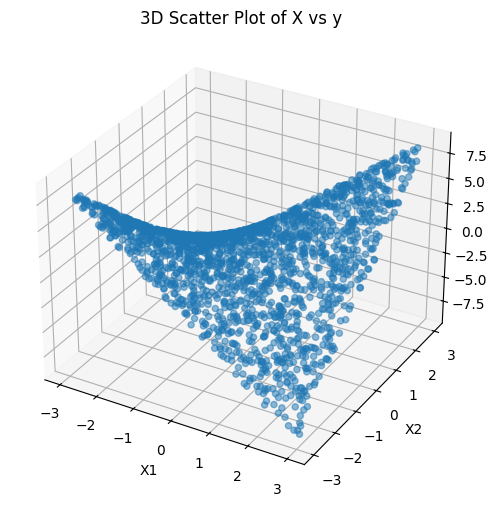

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0].cpu(), X[:, 1].cpu(), y.cpu(), alpha=0.5)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')
ax.set_title('3D Scatter Plot of X vs y')
plt.show()

### OPTIONAL: use Tensorboard embeddings projector to plot data

Tensorboard comes in handy for a bunch of stuff, see <a href="https://docs.pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html">How to use TensorBoard with PyTorch</a>

In [4]:
#for tensorboard embedding projector
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

# A log directory to store the events.
log_dir = "log_dir/custom_embeddings_torch"

# 1. Prepare your data (replace with your own).
vectors = torch.cat([X, torch.zeros(X.shape[0], 1, device=X.device)], dim=1)
vectors[:,2] = y
metadata = [f"label_{i}" for i in range(len(vectors))]

print (vectors.shape)  # Should be (num_samples, embedding_dim)
print(len(metadata))

# 2. Create a SummaryWriter and add the embedding.
writer = SummaryWriter(log_dir)
writer.add_embedding(vectors, metadata=metadata)
writer.close()

print(f"Embedding data logged to {log_dir}")

#to call up tensorboard, run following in terminal,
# from directory this notebook is in, choose projector
# tensorboard --logdir=logs


2025-09-10 15:47:05.722852: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


torch.Size([2000, 3])
2000
Embedding data logged to log_dir/custom_embeddings_torch


## 3) Train/Val split and feature scaling

Note that there are no for loops, vectorized operations only

In [5]:
# Shuffle the dataset and split into training and validation sets
idx = torch.randperm(len(X))
n_train = int(0.8 * len(X))
tr_idx, va_idx = idx[:n_train], idx[n_train:]

# Select training and validation data
Xtr, ytr = X[tr_idx], y[tr_idx]
Xva, yva = X[va_idx], y[va_idx]

# Compute mean and std from training features for normalization
# The 0 means compute along the 0th dimension (i.e. for each column/feature)
x_mean, x_std = Xtr.mean(0), Xtr.std(0).clamp_min(1e-6)

#normalize features (you will do this a lot in future assignments)
Xtr_n = (Xtr - x_mean) / x_std
Xva_n = (Xva - x_mean) / x_std

# Create DataLoaders for training and validation sets
train_loader = DataLoader(TensorDataset(Xtr_n, ytr), batch_size=128, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva_n, yva), batch_size=256, shuffle=False)

# Show shapes for sanity check
Xtr_n.shape, ytr.shape, Xva_n.shape, yva.shape


(torch.Size([1600, 2]),
 torch.Size([1600]),
 torch.Size([400, 2]),
 torch.Size([400]))

## 4) Define the MLP model

torch.nn has the classes necessary for building Neural Networks 

In [6]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    """
    A simple fully-connected neural network (Multi-Layer Perceptron).

    Inputs:
      - in_dim:  number of input features per example (e.g., 2 if x = [x1, x2])
      - hidden:  sizes of the two hidden layers (tuple of ints)
      - out_dim: number of outputs (1 for regression; >=2 for multi-class logits)

    Expected input shape to forward(x):
      - x: [batch_size, in_dim]
    """

    def __init__(self, in_dim=2, hidden=(64, 64), out_dim=1):
        super().__init__()  # initialize nn.Module internals

        # Fully-connected (linear) layers: y = x @ W^T + b        
        self.fc1 = nn.Linear(in_dim, hidden[0]) # fc1 maps from in_dim -> hidden[0]
        self.fc2 = nn.Linear(hidden[0], hidden[1]) # fc2 maps from hidden[0] -> hidden[1]
        self.fc3 = nn.Linear(hidden[1], out_dim) # fc3 maps from hidden[1] -> out_dim (final predictions/logits)

        # Nonlinearity: ReLU(x) = max(0, x). Adds capacity to learn nonlinear patterns.
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass: how the input tensor flows through the layers.

        x: [batch_size, in_dim]
        returns:
          - if out_dim == 1: [batch_size]  (due to squeeze at the end)
          - if out_dim  > 1: [batch_size, out_dim]
        """
        # Layer 1: linear transform, then ReLU
        x = self.relu(self.fc1(x))  # -> [batch_size, hidden[0]]

        # Layer 2: linear transform, then ReLU
        x = self.relu(self.fc2(x))  # -> [batch_size, hidden[1]]

        # Output layer: linear transform to out_dim (no activation here for regression or logits)
        x = self.fc3(x)             # -> [batch_size, out_dim]

        # If we're doing single-output regression (out_dim == 1), remove the last dimension
        # so shape becomes [batch_size] instead of [batch_size, 1].
        # If you prefer to keep shape [batch_size, 1], delete the squeeze.
        return x.squeeze(-1)


model = MLP(in_dim=2, hidden=(12, 12)).to(device)
model


MLP(
  (fc1): Linear(in_features=2, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=1, bias=True)
  (relu): ReLU()
)

## 5) Train and evaluate functions

In [7]:
import torch


@torch.no_grad()  # Disable gradient tracking inside this function (saves memory/compute)
def evaluate(model, loader, criterion, device):
    """
    Puts the model in evaluation mode and computes the average loss
    over all batches in `loader`.

    Args:
        model:     a torch.nn.Module
        loader:    DataLoader for validation/test data
        criterion: loss function (e.g., nn.MSELoss())
        device:    'cuda' or 'cpu' device to run on

    Returns:
        avg_loss (float): mean loss over the dataset
    """
    model.eval()          # turn off dropout / use running stats for batchnorm, etc.
    total_loss, total_n = 0.0, 0

    for xb, yb in loader:
        # Move the current batch to the right device
        xb, yb = xb.to(device), yb.to(device)

        # Forward pass only (no grad because of @torch.no_grad)
        preds = model(xb)
        loss = criterion(preds, yb)

        # Accumulate *sum* of losses so we can compute dataset average
        total_loss += loss.item() * xb.size(0)  # multiply by batch size
        total_n    += xb.size(0)

    return total_loss / total_n  # average loss over all examples


def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=200, log_every=20):
    """
    Standard training loop with per-epoch validation.

    Args:
        model:        a torch.nn.Module
        train_loader: DataLoader for training data
        val_loader:   DataLoader for validation data
        criterion:    loss function (e.g., nn.MSELoss())
        optimizer:    torch.optim optimizer (e.g., Adam)
        device:       'cuda' or 'cpu'
        epochs:       number of training epochs
        log_every:    how often to print progress (in epochs)
    """
    for epoch in range(1, epochs + 1):
        model.train()                # enable training behavior (dropout, batchnorm updates, etc.)
        running_loss, total_n = 0.0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            # 1) Reset gradients from the previous step
            optimizer.zero_grad(set_to_none=True)
            #    set_to_none=True can be a tiny memory/perf win vs. zeroing to 0.0

            # 2) Forward pass: compute predictions and loss
            preds = model(xb)
            loss  = criterion(preds, yb)

            # 3) Backward pass: compute gradients w.r.t. parameters
            loss.backward()

            # 4) Update parameters using the optimizer
            optimizer.step()

            # Track running training loss (sum over all samples)
            running_loss += loss.item() * xb.size(0)
            total_n      += xb.size(0)

        # Average train loss this epoch
        train_mse = running_loss / total_n

        # Evaluate on the validation set (no-grad inside)
        val_mse = evaluate(model, val_loader, criterion, device)

        # Print progress
        if (epoch % log_every == 0) or (epoch == 1):
            print(f"epoch {epoch:03d} | train MSE {train_mse:.4f} | val MSE {val_mse:.4f}")


## 5) Loss & optimizer

torch.nn also has the loss functions and optimizers for training

In [8]:
lr=1e-2
criterion = nn.MSELoss()  #dont need to create your own loss function, pytorch has many built in
optimizer = torch.optim.SGD(model.parameters(), lr=lr)    #dont need to subtract learning rate*grad for every parameter,pytorch does it for you
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


## 6) Train Model

In [9]:
train(model, train_loader, val_loader, criterion, optimizer, device, epochs=400, log_every=20)

epoch 001 | train MSE 8.5679 | val MSE 7.5891
epoch 020 | train MSE 0.3932 | val MSE 0.3936
epoch 040 | train MSE 0.2043 | val MSE 0.1941
epoch 060 | train MSE 0.1518 | val MSE 0.1414
epoch 080 | train MSE 0.1064 | val MSE 0.0903
epoch 100 | train MSE 0.0706 | val MSE 0.0581
epoch 120 | train MSE 0.0503 | val MSE 0.0409
epoch 140 | train MSE 0.0379 | val MSE 0.0306
epoch 160 | train MSE 0.0302 | val MSE 0.0251
epoch 180 | train MSE 0.0270 | val MSE 0.0233
epoch 200 | train MSE 0.0257 | val MSE 0.0230
epoch 220 | train MSE 0.0232 | val MSE 0.0223
epoch 240 | train MSE 0.0216 | val MSE 0.0196
epoch 260 | train MSE 0.0207 | val MSE 0.0217
epoch 280 | train MSE 0.0199 | val MSE 0.0186
epoch 300 | train MSE 0.0189 | val MSE 0.0190
epoch 320 | train MSE 0.0187 | val MSE 0.0189
epoch 340 | train MSE 0.0180 | val MSE 0.0171
epoch 360 | train MSE 0.0183 | val MSE 0.0183
epoch 380 | train MSE 0.0171 | val MSE 0.0194
epoch 400 | train MSE 0.0171 | val MSE 0.0171


<mark>Loss is dropping slowly but is dropping (A higher learning rate would probably help).  We can go on until val MSE loss starts to rise. 
<br>
Show train verses validation loss plot on board, indicate when validation loss starts to rise you should stop training

## 7) Sample predictions (sanity check)

In [10]:

@torch.no_grad()    # indicates we are not training a model
                    # Disables the PyTorch autograd engine within this scope, preventing the computation and storage of gradients.
                    # Significantly reduces memory consumption and increases computation speed
def preview_predictions(model, X_raw, y_true):
    model.eval()    # no effect on this model, on more complex nets will turn off dropout, etc.
    preds = model(X_raw.to(device))  #get predictions for this batch
    for i in range(len(X_raw)):
        x1, x2 = X_raw[i].tolist()
        print(f"x=({x1:+.3f},{x2:+.3f})  y_true={y_true[i]:+.3f}  y_pred={preds[i]:+.3f} ")

print("Validation set preview:")
preview_predictions(model, Xva_n[:5], yva[:5])


Validation set preview:
x=(+1.608,-0.618)  y_true=-3.090  y_pred=-3.003 
x=(+1.656,+1.036)  y_true=+4.945  y_pred=+4.939 
x=(+0.065,+0.448)  y_true=+0.074  y_pred=+0.096 
x=(-1.197,-1.067)  y_true=+3.928  y_pred=+3.950 
x=(-0.948,-1.171)  y_true=+3.410  y_pred=+3.458 


### Plot actuals verses predicted (if model is accurate they should be roughly equal)

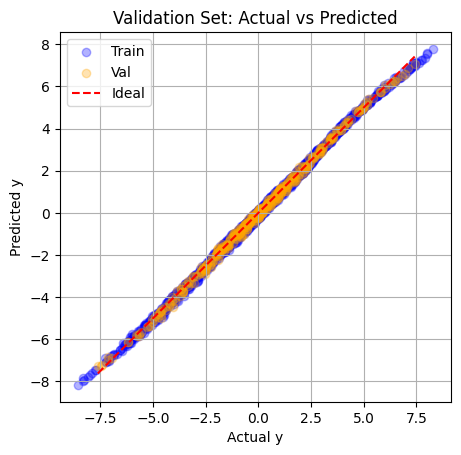

In [13]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    preds_tr = model(Xtr_n.to(device))
    preds_val= model(Xva_n.to(device))

plt.scatter(ytr, preds_tr, alpha=0.3, color='blue', label='Train')
plt.scatter(yva, preds_val, alpha=0.3, color='orange', label='Val')
plt.plot([yva.min(), yva.max()], [yva.min(), yva.max()], 'r--', label='Ideal')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Validation Set: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

## 8) Checkpointing (Saving and Loading a model)

In [14]:
# ---------------------------
# Saving a training checkpoint
# ---------------------------

# torch.save can write (almost) any Python object to disk.
# Common practice: save a DICTIONARY with everything you’ll need to resume training later.
torch.save({
    "model": model.state_dict(),      # model "weights" (parameters as plain tensors)
    "opt": optimizer.state_dict()     # optimizer state (e.g., Adam's moment estimates)
}, "ckpt_demo.pt")

print("Saved to ckpt_demo.pt")

# ---------------------------
# Loading a training checkpoint
# ---------------------------

# torch.load reads the file back into memory.
# map_location=device makes sure tensors are moved to the right device (e.g., "cpu" or "cuda").
ckpt = torch.load("ckpt_demo.pt", map_location=device)

# Put the saved weights back into the model.
# Note: the model architecture in code must MATCH the one that created the checkpoint.
model.load_state_dict(ckpt["model"])

# Restore the optimizer’s internal state so you can continue training seamlessly
# (keeps momentum/Adam moments, etc.).
optimizer.load_state_dict(ckpt["opt"])

print("Reloaded checkpoint.")



Saved to ckpt_demo.pt
Reloaded checkpoint.


## 9) (Optional) Try things


- Change hidden sizes `(32, 32)` or `(128, 128)` and compare validation MSE.
- change learning rate to 0.5, notice model does not converge.  it is 'jumping' past the solution because each param is being adjusted too much
